In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from numpy.random import seed
seed(42)

import tensorflow
tensorflow.random.set_seed(42)

In [3]:
import os
import pandas as pd
import math
import numpy as np

### Dataframes

In [4]:
REPOSITORY_PREFIX = 'https://raw.githubusercontent.com/RonildoSilva/datasets/main/'

In [5]:
# SFZ - Alimentos Congeneres
df_train = pd.read_csv(REPOSITORY_PREFIX+'df_train_keras_tk_reg_al_cg_prefix.csv')
df_val = pd.read_csv(REPOSITORY_PREFIX+'df_val_keras_tk_reg_al_cg_prefix.csv')
df_test = pd.read_csv(REPOSITORY_PREFIX+'df_test_keras_tk_reg_al_cg_prefix.csv')

In [6]:
df_train.columns

Index(['CaseID', 'Activity', 'Duration', 'Timestamp', 'Duration Float',
       'Time to conclusion', 'Passed Time', 'Step', 'Prefix', 'Activity Cat'],
      dtype='object')

In [7]:
#df_train = df_train.rename(columns={"Time to conclusion": "TimeConclusion", "CaseID": "Case ID", "Passed Time": "PassedTime"})
#df_val = df_val.rename(columns={"Time to conclusion": "TimeConclusion", "CaseID": "Case ID", "Passed Time": "PassedTime"})
#df_test = df_test.rename(columns={"Time to conclusion": "TimeConclusion", "CaseID": "Case ID", "Passed Time": "PassedTime"})

In [8]:
df_train = df_train[df_train['Time to conclusion'] != 0]
df_val = df_val[df_val['Time to conclusion'] != 0]
df_test = df_test[df_test['Time to conclusion'] != 0]

In [9]:
print(df_train['Time to conclusion'].std(),
df_val['Time to conclusion'].std(),
df_test['Time to conclusion'].std())

109.52826374667757 89.61941389322281 89.67646037378331


In [10]:
#len(df_test['Case ID'].unique())

In [11]:
MAX_LEN_TRACE_TRAIN = df_train['Step'].max()

In [12]:
df_test['Step'].max()

49

### Features extraction

In [13]:
from keras.preprocessing.text import Tokenizer

### Features selection

In [14]:
MAX_LEN = max(max(df_train['Step']),max(df_val['Step']),max(df_test['Step']))

In [15]:
df_prefix_train = df_train['Prefix'].str.split(',', expand = True)
col = df_prefix_train.shape[1]
for i in range(MAX_LEN - df_prefix_train.shape[1]):
    df_prefix_train.insert(df_prefix_train.shape[1], col+i, None)
    #print(i)

In [16]:
df_prefix_val = df_val['Prefix'].str.split(',', expand = True)
col = df_prefix_val.shape[1]
for i in range(MAX_LEN - df_prefix_val.shape[1]):
    df_prefix_val.insert(df_prefix_val.shape[1], col+i, None)
    #print(i)

In [17]:
df_prefix_test = df_test['Prefix'].str.split(',', expand = True)
col = df_prefix_test.shape[1]
for i in range(MAX_LEN - df_prefix_test.shape[1]):
    df_prefix_test.insert(df_prefix_test.shape[1], col+i, None)
    #print(i)

In [18]:
df_prefix_train = df_prefix_train.fillna('')
df_prefix_val = df_prefix_val.fillna('')
df_prefix_test = df_prefix_test.fillna('')

In [19]:
tokenize_mode = 'sequences_to_matrix'

In [20]:
kerasTokenizer = Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=",")


train_txt = df_train['Activity'].values
val_txt = df_val['Activity'].values
test_txt = df_test['Activity'].values

kerasTokenizer.fit_on_texts(train_txt)

train_sequences = kerasTokenizer.texts_to_sequences(train_txt)
val_sequences = kerasTokenizer.texts_to_sequences(val_txt)
test_sequences = kerasTokenizer.texts_to_sequences(test_txt)

train_matrix = kerasTokenizer.texts_to_matrix(train_txt, mode='binary')
val_matrix = kerasTokenizer.texts_to_matrix(val_txt, mode='binary')
test_matrix = kerasTokenizer.texts_to_matrix(test_txt, mode='binary')


train_sequences_matrix = kerasTokenizer.sequences_to_matrix(train_sequences, mode='binary')
val_sequences_matrix = kerasTokenizer.sequences_to_matrix(val_sequences, mode='binary')
test_sequences_matrix = kerasTokenizer.sequences_to_matrix(test_sequences, mode='binary')

Text to sequences

In [21]:
df_train_sequences = pd.DataFrame(train_sequences).fillna(0).astype(int)
col = df_train_sequences.shape[1]
for i in range(MAX_LEN - df_train_sequences.shape[1]):
    df_train_sequences.insert(df_train_sequences.shape[1], col+i, 0)
    #print(i)


df_test_sequences = pd.DataFrame(test_sequences).fillna(0).astype(int)
col = df_test_sequences.shape[1]
for i in range(MAX_LEN - df_test_sequences.shape[1]):
    df_test_sequences.insert(df_test_sequences.shape[1], col+i, 0)
    #print(i)

df_val_sequences = pd.DataFrame(val_sequences).fillna(0).astype(int)
col = df_val_sequences.shape[1]
for i in range(MAX_LEN - df_val_sequences.shape[1]):
    df_val_sequences.insert(df_val_sequences.shape[1], col+i, 0)
    #print(i)


In [22]:
if(tokenize_mode == 'sequences_to_matrix'):
    X_train = np.concatenate((df_train[['Step', 'Duration Float', 'Passed Time']].values,
                              train_sequences_matrix), axis=1)
    y_train = df_train[['Time to conclusion']].values

    X_test = np.concatenate((df_test[['Step', 'Duration Float', 'Passed Time']].values,
                             test_sequences_matrix), axis=1)
    y_test = df_test[['Time to conclusion']].values


    X_val = np.concatenate((df_val[['Step', 'Duration Float', 'Passed Time']].values,
                            val_sequences_matrix), axis=1)
    y_val = df_val[['Time to conclusion']].values

In [23]:
X_train_ml = np.concatenate((X_train, X_val), axis=0)
y_train_ml = np.concatenate((y_train, y_val), axis=0)

In [24]:
print(X_train.shape)

(13655, 101)


In [25]:
print(X_train_ml.shape)

(19063, 101)


### ML Experiment

In [26]:
! pip install lightgbm
! pip install xgboost

In [27]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
import lightgbm as ltb

regressors = [
        {'nome' : 'DummyRegressor', 'regressor':  DummyRegressor(strategy='mean')},
        {'nome': 'LinearRegression', 'regressor': LinearRegression(fit_intercept=False)},
        {'nome': 'RandomForestRegressor',  'regressor': RandomForestRegressor(n_estimators=20, max_features='auto',
                                                                              bootstrap=True, warm_start=True, max_depth=19, random_state=0)},
        {'nome' : 'XGBoostRegressor', 'regressor': XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)},
        {'nome' : 'LightGBM Regressor', 'regressor': ltb.LGBMRegressor(random_state=0)}
]

In [28]:
import numpy as np
import scipy.stats as st

def ci(data):
  #create 95% confidence interval for population mean weight
  return st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))


import time
from sklearn.metrics import mean_absolute_error
from google.colab import files

cols = [
        'Nome do modelo', 'MAE', 'CI'
       ]

data_result = []


if(2 > 3):
  for regressor in regressors:
      t1 = time.time()
      if(regressor['nome'] == 'LightGBM Regressor'):
        regr = regressor['regressor'].fit(X_train_ml, y_train_ml, categorical_feature=[i for i in range(0,MAX_LEN_TRACE_TRAIN+1)])
      else:
        regr = regressor['regressor'].fit(X_train_ml, y_train_ml)
      tf = time.time()

      y_pred = regr.predict(X_test)
      mae = mean_absolute_error(y_test, y_pred)

      y_t = []

      for t in y_test:
        cur_t = str(t)
        str_v = cur_t.replace('[','')
        str_v = str_v.replace(']','')
        y_t.append(float(str_v))


      int_conf = ci(abs(y_t - np.squeeze(y_pred)))

      line = [
          regressor['nome'],
          mae,
          int_conf
      ]

      data_result.append(line)

      df_results = pd.DataFrame(list(zip(y_test, np.squeeze(y_pred))),columns =['y_test', 'y_pred'])
      df_results.to_csv('Baseline AL_CG_'+regressor['nome']+'.csv', index=False)
      files.download('Baseline AL_CG_'+regressor['nome']+'.csv')

  pd.DataFrame(data_result, columns=cols).sort_values(by='MAE', ascending=True).to_csv('Baseline AL_CG_.csv')
  files.download('Baseline AL_CG_.csv')

### Deep learning Experiment

Deep learning model definition

In [29]:
#! pip install keras_self_attention

In [30]:
#from keras_self_attention import SeqSelfAttention

In [32]:
import keras

from tensorflow import keras
import tensorflow as tf

from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import PReLU
from keras.layers import BatchNormalization
from keras.layers import Input
from keras.layers import Embedding
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Masking

from tensorflow.keras.layers import concatenate

from keras.utils import plot_model
from keras.utils import model_to_dot

from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback


from keras.layers import Activation
from keras.initializers import Constant

from keras.regularizers import l2

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [34]:
df_train['Step'].max()

60

In [35]:
df_val['Step'].max()

69

In [36]:
df_test['Step'].max()

49

In [37]:
TIME_COLS = ['Duration Float', 'Passed Time', 'Step']

In [38]:
dl_x_train = train_sequences_matrix
dl_x_val = val_sequences_matrix
dl_x_test = test_sequences_matrix

In [39]:
dl_x_t_train = df_train[TIME_COLS].values
dl_x_t_val = df_val[TIME_COLS].values
dl_x_t_test = df_test[TIME_COLS].values

In [40]:
dl_x_train = dl_x_train.reshape(dl_x_train.shape[0], dl_x_train.shape[1], 1)
dl_x_val = dl_x_val.reshape(dl_x_val.shape[0], dl_x_val.shape[1], 1)
dl_x_test = dl_x_test.reshape(dl_x_test.shape[0], dl_x_test.shape[1], 1)

In [41]:
dl_x_t_train = dl_x_t_train.reshape(dl_x_t_train.shape[0], dl_x_t_train.shape[1], 1)
dl_x_t_val = dl_x_t_val.reshape(dl_x_t_val.shape[0], dl_x_t_val.shape[1], 1)
dl_x_t_test = dl_x_t_test.reshape(dl_x_t_test.shape[0], dl_x_t_test.shape[1], 1)

In [42]:
print(dl_x_train.shape, dl_x_t_train.shape)

(13655, 98, 1) (13655, 3, 1)


In [43]:
n_activities = len(pd.concat([df_train, df_val, df_test], ignore_index=True)['Activity Cat'].unique())

In [44]:
n_activities

444

In [45]:
shape = train_sequences_matrix.shape[1]
shape_t = len(TIME_COLS)

- input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
- output_dim: Integer. Dimension of the dense embedding.


In [46]:
! pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=683546b8aaf3b59906e46f2ea53ae8925edc49a0e615c492087f0c0f63f23a2f
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [47]:
from keras_self_attention import SeqSelfAttention

445 444


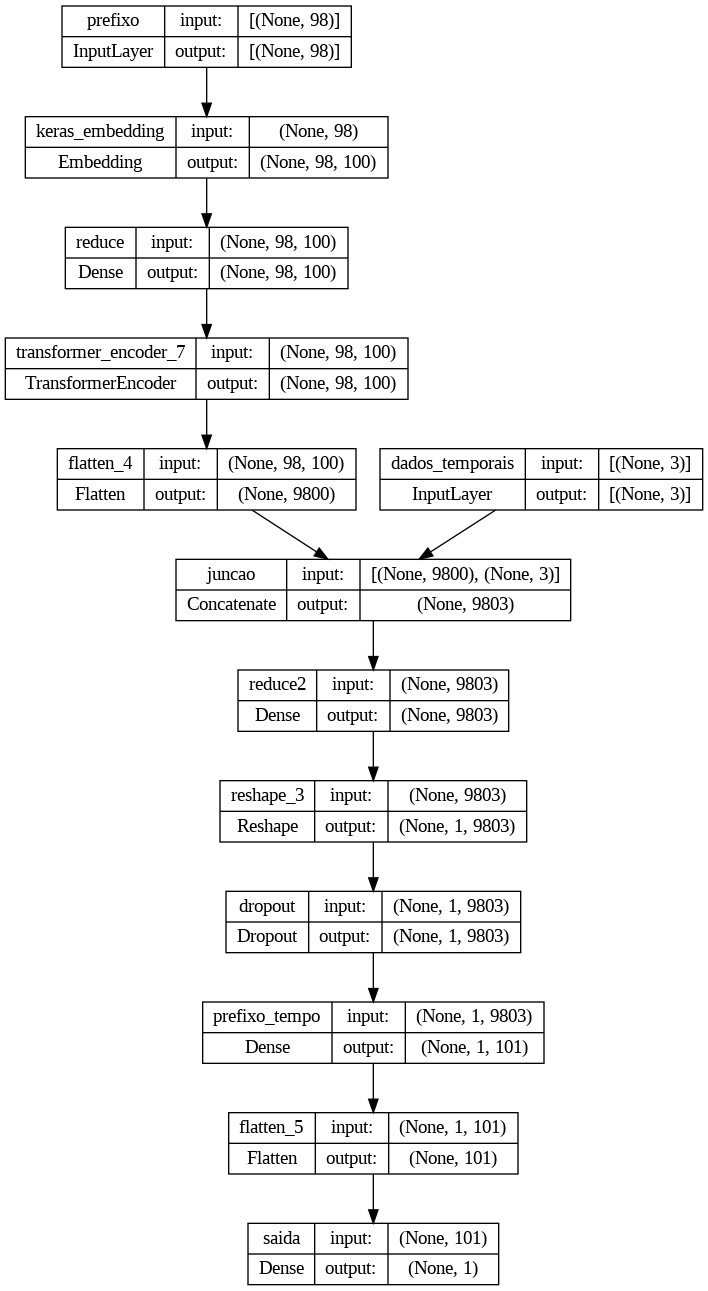

In [56]:
seq_length = shape
seq_length_t = shape_t

input_dim = n_activities + 1

activity_input = Input(shape=(seq_length,), name='prefixo')
time_input = Input(shape=(shape_t,), name='dados_temporais')

embedding_size = n_activities

print(input_dim, embedding_size)
embedding_size = 100
embedding = Embedding(output_dim=embedding_size,
                      input_dim=input_dim,
                      input_length=seq_length,
                      name='keras_embedding')(activity_input)

#
embedding = Dense(100, name='reduce')(embedding)

num_heads = 2
enc = TransformerEncoder(embedding_size, input_dim, num_heads)(embedding)

f = Flatten()(enc)
x = concatenate([f, time_input], name='juncao')

x = Dense(9803, name='reduce2')(x)


x = Reshape((1, 9803),
            input_shape = (1, ((seq_length * n_activities) + seq_length_t) ))(x)


x = Dropout(0.2)(x)

x = Dense((seq_length + seq_length_t),
          activation='relu',
          name='prefixo_tempo')(x)

x = Flatten()(x)

x = Dense(1, activation='linear', name='saida')(x)

model = Model(inputs=[activity_input , time_input], outputs=[x])

#model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [57]:
nadam = keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.7, beta_2=0.9, epsilon=1e-07, name="Nadam")

adam = keras.optimizers.Nadam(learning_rate=0.01, epsilon=0.01)

model.compile(
    optimizer=nadam,
    loss="mean_absolute_error",
    metrics=["mean_absolute_error"]
)

es = EarlyStopping(monitor='mean_absolute_error',
                   min_delta=1e-07, #min_delta=1e-04,
                   patience=10, verbose=1)

history = model.fit([dl_x_train, dl_x_t_train], y_train,
                    epochs=150,
                    batch_size=1200,
                    callbacks=[TqdmCallback(verbose=0), es],
                    validation_data=[[dl_x_val, dl_x_t_val], y_val],
                    verbose=0)

0epoch [00:00, ?epoch/s]

Epoch 150: early stopping


Loss

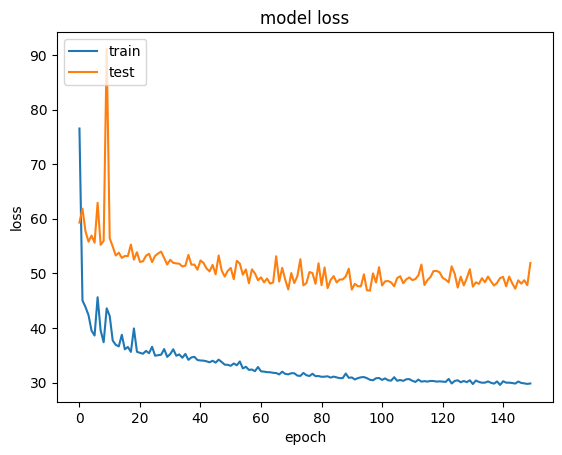

In [58]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
test_predicton = model.predict([dl_x_test,dl_x_t_test])

164/164 [==============================] - 1s 7ms/step


In [60]:
test_predicton.shape

(5222, 1)

In [61]:
y_test.shape

(5222, 1)

In [62]:
from sklearn.metrics import mean_absolute_error

In [63]:
mae_error = mean_absolute_error(y_test, test_predicton)

In [65]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [66]:
y_t = []

for t in y_test:
  cur_t = str(t)
  str_v = cur_t.replace('[','')
  str_v = str_v.replace(']','')
  y_t.append(float(str_v))

int_conf = mean_confidence_interval(abs(y_t - np.squeeze(test_predicton)))

print('ci: ' , mae_error, int_conf)

ci:  51.1703187191101 (51.1703187191101, 49.18175932266062, 53.15887811555958)


CSV resultados pred x real

In [67]:
from google.colab import files

df_results = pd.DataFrame(list(zip(y_test, np.squeeze(test_predicton))),columns =['y_test', 'y_pred'])
df_results.to_csv('F) AL_CG_TRANSFORMER_ENCODER_PRED_REAL.csv', index=False)

files.download('F) AL_CG_TRANSFORMER_ENCODER_PRED_REAL.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Avaliação por etapa

In [68]:
MAX_STEP = df_test['Step'].max()

In [69]:
MAX_STEP

49

In [70]:
df_test['Step'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [71]:
df_full_test = pd.DataFrame(dl_x_test.reshape(dl_x_test.shape[0], (dl_x_test.shape[1]*dl_x_test.shape[2])))
df_full_test['Step'] = df_test['Step']
df_full_test['Time to conclusion'] = df_test['Time to conclusion']

In [72]:
dl_full_t_test = pd.DataFrame(dl_x_t_test.reshape(dl_x_t_test.shape[0], (dl_x_t_test.shape[1]*dl_x_t_test.shape[2])))
dl_full_t_test['Step'] = df_test['Step']

In [73]:
step = list()
mae = list()

for i in range(1, MAX_STEP+1):
  dl_x__local_test = df_full_test[df_full_test['Step'] == i]
  ACT_COLS = dl_x__local_test.columns.tolist()
  ACT_COLS.remove('Step')
  ACT_COLS.remove('Time to conclusion')
  x_local = dl_x__local_test[ACT_COLS].values

  dl_x_t_local_test = dl_full_t_test[dl_full_t_test['Step'] == i]
  TIME_COLS = dl_x_t_local_test.columns.tolist()
  TIME_COLS.remove('Step')
  x_t_local = dl_x__local_test[TIME_COLS].values

  print(dl_x_t_local_test.shape)

  y_local_test = df_full_test[df_full_test['Step'] == i]['Time to conclusion']
  local_test_predicton = model.predict([[x_local, x_t_local]])

  mae_error = mean_absolute_error(y_local_test, local_test_predicton)

  mae.append(mae_error)
  step.append(i)

(259, 4)
9/9 [==============================] - 0s 11ms/step
(259, 4)
9/9 [==============================] - 0s 10ms/step
(259, 4)
9/9 [==============================] - 0s 9ms/step
(259, 4)
9/9 [==============================] - 0s 9ms/step
(259, 4)
9/9 [==============================] - 0s 13ms/step
(258, 4)
9/9 [==============================] - 0s 11ms/step
(257, 4)
9/9 [==============================] - 0s 11ms/step
(256, 4)
8/8 [==============================] - 0s 11ms/step
(256, 4)
8/8 [==============================] - 0s 12ms/step
(253, 4)
8/8 [==============================] - 0s 11ms/step
(250, 4)
8/8 [==============================] - 0s 12ms/step
(247, 4)
8/8 [==============================] - 0s 12ms/step
(242, 4)
8/8 [==============================] - 0s 11ms/step
(225, 4)
8/8 [==============================] - 0s 13ms/step
(204, 4)
7/7 [==============================] - 0s 12ms/step
(182, 4)
6/6 [==============================] - 0s 9ms/step
(159, 4)
5/5 [=============

In [74]:
for s, m in zip(step,mae):
  print(s,m)

1 130.7400225908981
2 130.2778213831416
3 106.48831985747454
4 85.3869115919717
5 75.05509030316809
6 73.40112875036819
7 70.03933238748519
8 60.97031185476999
9 56.70110885501891
10 49.48736855718288
11 48.87329536991098
12 47.648692175538535
13 46.361315585459366
14 45.80431592741126
15 43.11869580426899
16 43.70907912449764
17 44.739656944195396
18 43.39472424031177
19 35.88345492088663
20 38.49947370260033
21 30.65324520195974
22 32.33233545578361
23 37.2488469591077
24 41.15973881710768
25 35.86174897503423
26 30.609864463564158
27 27.15448796762267
28 35.80951539331766
29 37.79818926094304
30 41.23374826847258
31 36.311702065147365
32 36.78399403810501
33 34.83187988784654
34 28.135497744871888
35 27.725082164637243
36 23.683612815886736
37 22.133039181213377
38 31.527384602446556
39 30.32902506030083
40 18.947316398577392
41 44.306317079671224
42 55.10636571655274
43 54.14067132568359
44 44.29813280639648
45 27.615700564575192
46 35.32630944671631
47 20.426897564697267
48 18.147

In [75]:
for s, m in zip(step,mae):
  print(str(round(m, 4)).replace('.',','))

130,74
130,2778
106,4883
85,3869
75,0551
73,4011
70,0393
60,9703
56,7011
49,4874
48,8733
47,6487
46,3613
45,8043
43,1187
43,7091
44,7397
43,3947
35,8835
38,4995
30,6532
32,3323
37,2488
41,1597
35,8617
30,6099
27,1545
35,8095
37,7982
41,2337
36,3117
36,784
34,8319
28,1355
27,7251
23,6836
22,133
31,5274
30,329
18,9473
44,3063
55,1064
54,1407
44,2981
27,6157
35,3263
20,4269
18,147
0,0555


In [76]:
np.mean(mae)

45.23006739504574